In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
1,899 cases (7 day average) as of Tue 11 May, -52.4 since Mon 10 May
81 hospitalised (7 day average) as of Wed 12 May, +0.0 since Wed 12 May
8 died (7 day average) as of Tue 11 May, +0.6 since Mon 10 May


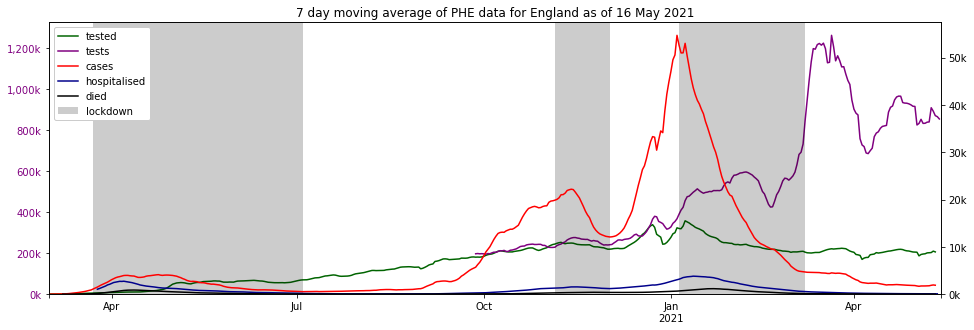

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

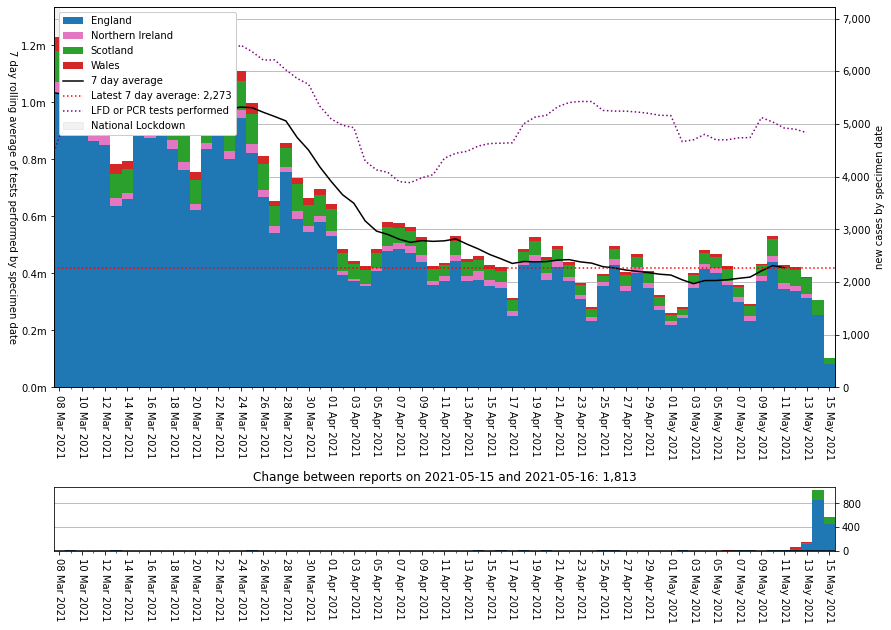

In [23]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1])

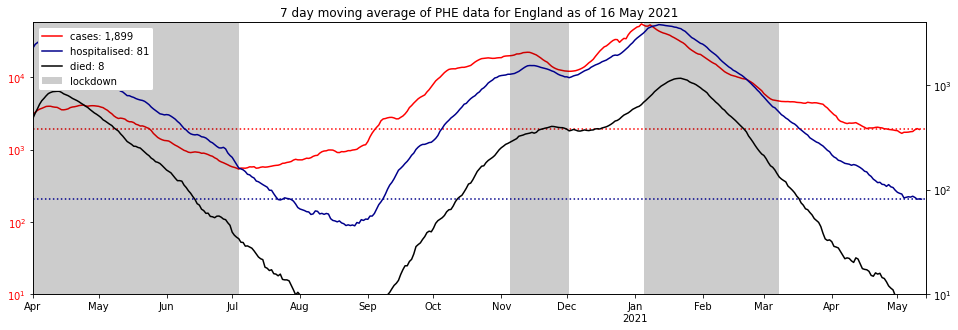

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

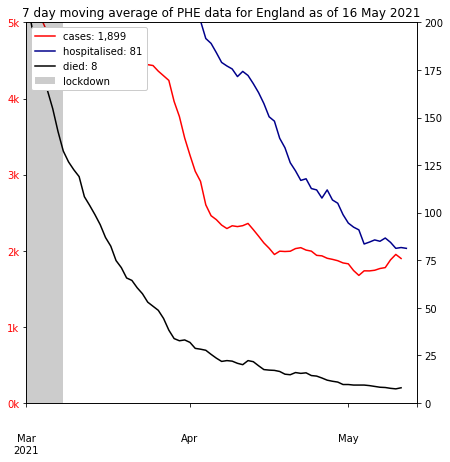

In [6]:
plot_summary(earliest_date='2021-03-01', show_latest=True, figsize=(7, 7),
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=5_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=200)

In [7]:
vaccination_changes()

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,17014522.0,30537954.0,13523432.0,56286961,30.228177,24.025870,45.745953
1,Northern Ireland,N92000002,552431.0,995905.0,443474.0,1893667,29.172553,23.418795,47.408652
2,Scotland,S92000003,1621031.0,3020335.0,1399304.0,5463300,29.671279,25.612798,44.715923
3,Wales,W92000004,915674.0,2019160.0,1103486.0,3152879,29.042472,34.999313,35.958215


'partial: 36,573,354 (54.8%), full: 20,103,658'

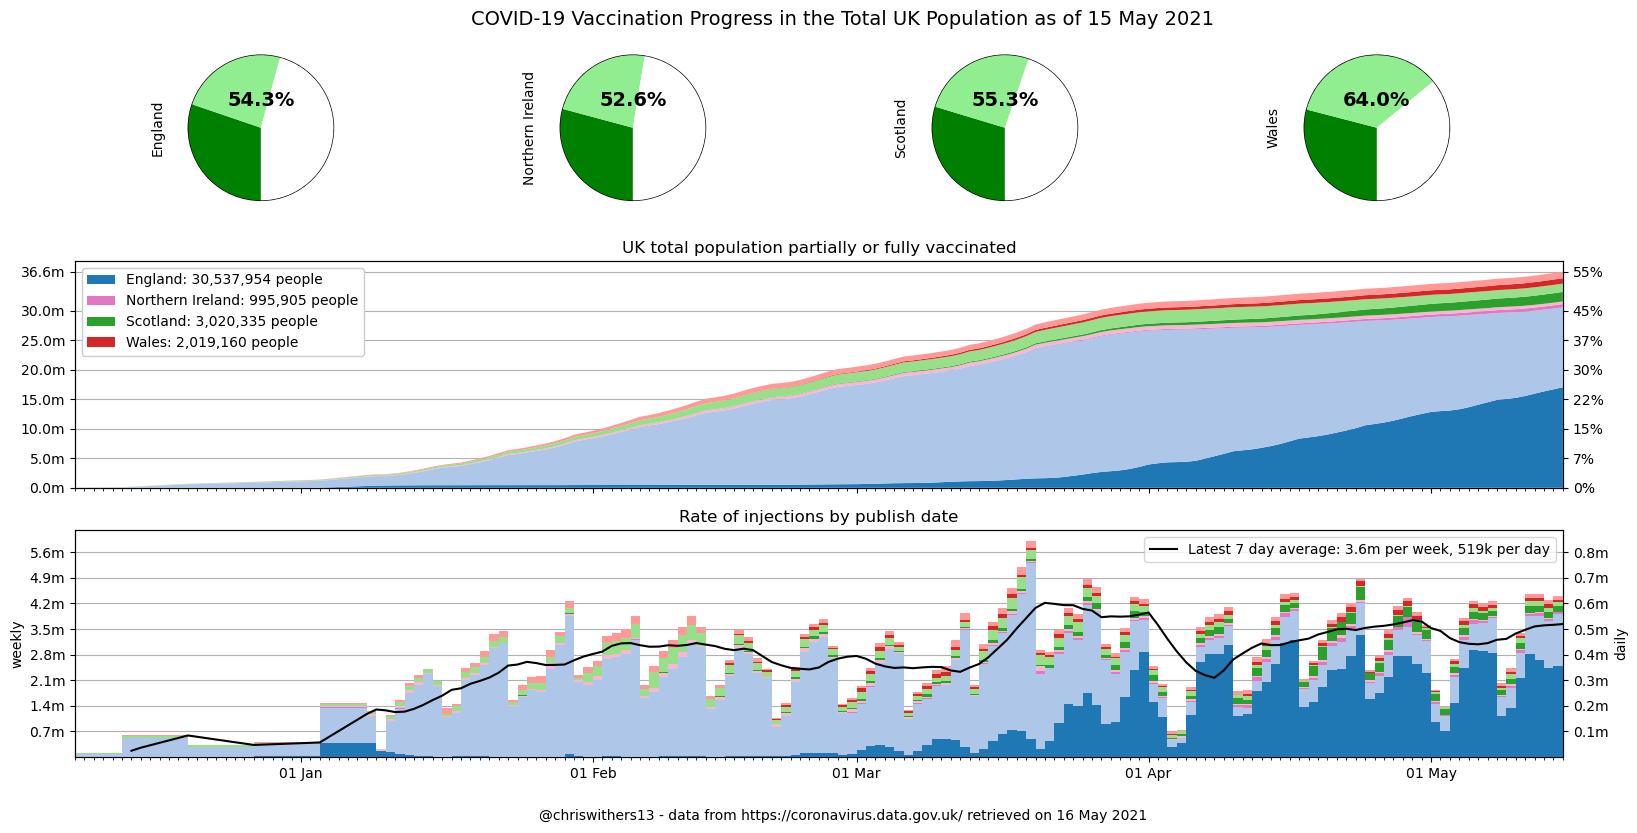

In [8]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

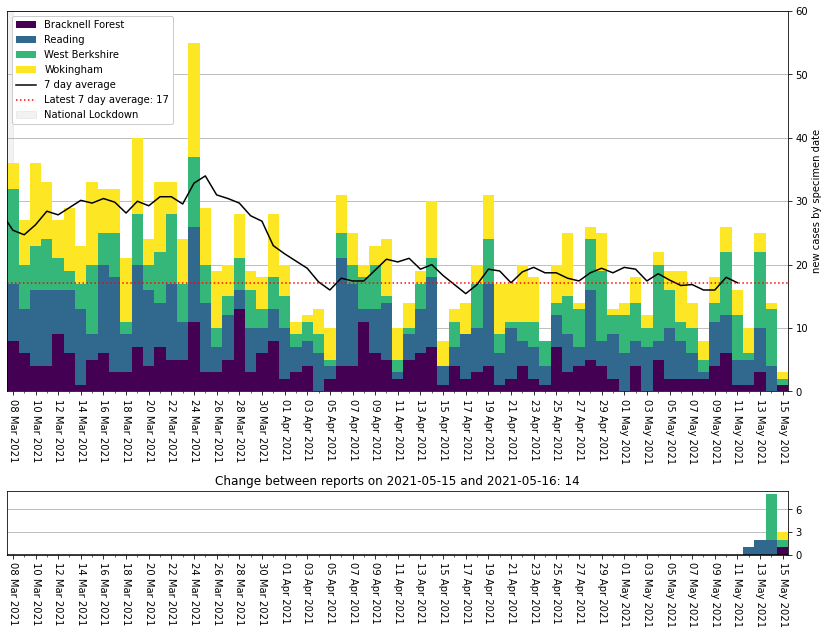

In [20]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], ylim=60)

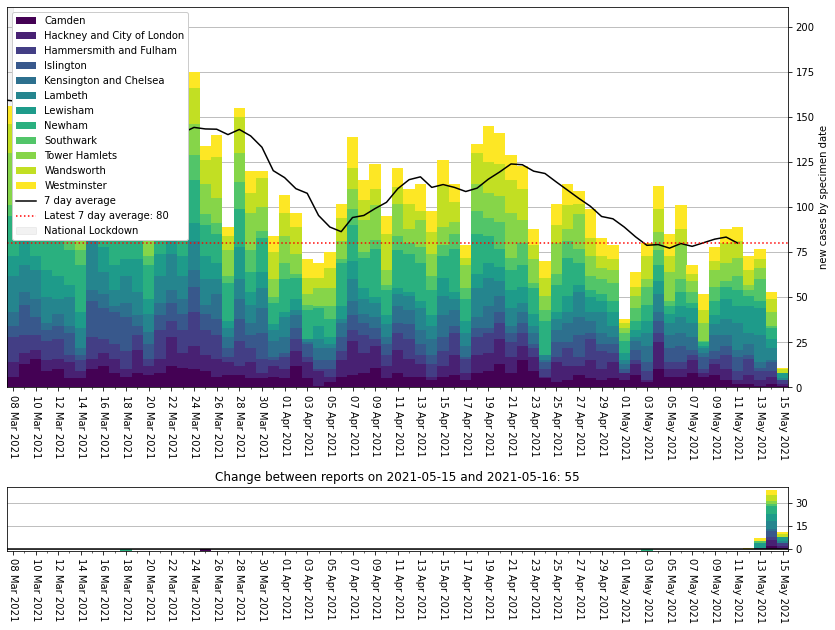

In [22]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1])

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,275.430360,792.0,2021-05-15
E06000055,Bedford,123.490986,214.0,2021-05-15
E06000008,Blackburn with Darwen,122.915776,184.0,2021-05-15
S12000049,Glasgow City,98.559515,624.0,2021-05-15
S12000011,East Renfrewshire,87.930493,84.0,2021-05-15
N09000005,Derry City and Strabane,85.270088,129.0,2021-05-15
E08000034,Kirklees,66.168395,291.0,2021-05-15
E07000117,Burnley,61.853351,55.0,2021-05-15
E09000018,Hounslow,54.139060,147.0,2021-05-15


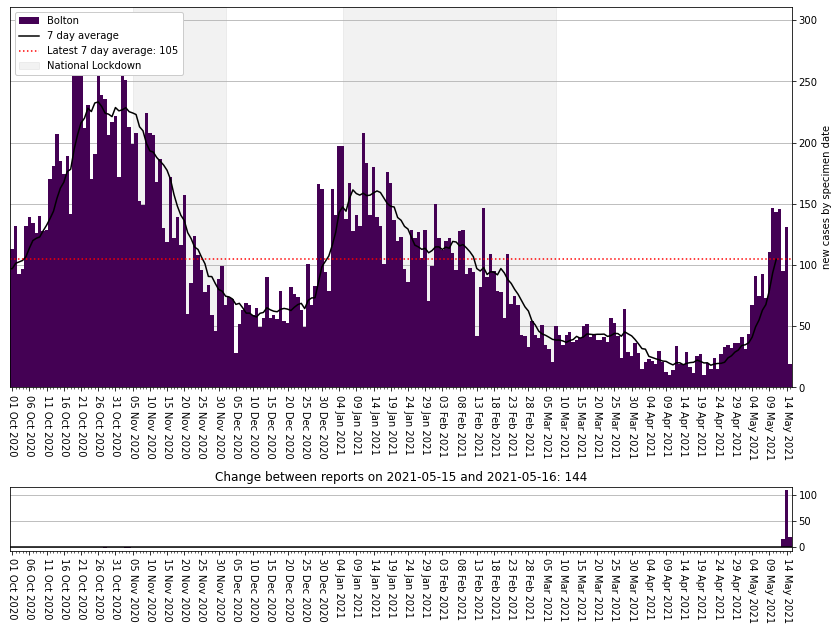

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,275.430360,792.0,2021-05-15
S12000049,Glasgow City,98.559515,624.0,2021-05-15
E08000035,Leeds,41.228587,327.0,2021-05-15
E08000034,Kirklees,66.168395,291.0,2021-05-15
E08000019,Sheffield,40.693986,238.0,2021-05-15
E08000003,Manchester,41.421124,229.0,2021-05-15
E06000055,Bedford,123.490986,214.0,2021-05-15
E08000032,Bradford,34.829263,188.0,2021-05-15
E06000008,Blackburn with Darwen,122.915776,184.0,2021-05-15


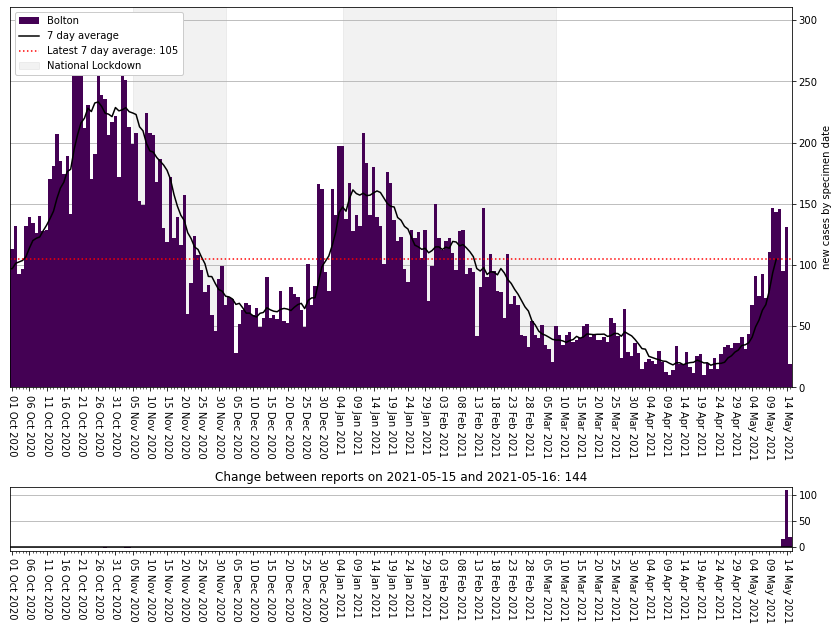

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [24]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

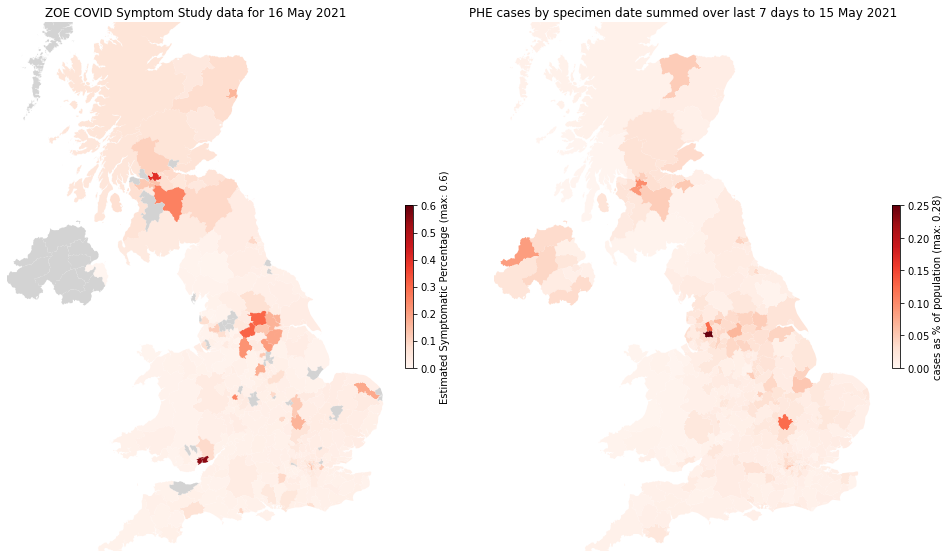

In [25]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [26]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...